In [1]:
%matplotlib widget

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from jacques import kcqe

In [2]:
# Data generation adapted from https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
# Fix random state for reproducibility
np.random.seed(19680801)

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

n = 500
x0 = randrange(n, -2. * np.pi, 2. * np.pi)
x1 = randrange(n, -2. * np.pi, 2. * np.pi)
y = 10. * np.cos(x0) + 0.5 * x1**2 + np.random.normal(loc=0., scale=5., size=n)

In [14]:
x = np.concatenate([x0[:, np.newaxis], x1[:, np.newaxis]], axis=1)
grid_size = 120
x_test = np.concatenate(
    [np.tile(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis],
        np.repeat(np.linspace(-2. * np.pi, 2. * np.pi, num = grid_size), grid_size)[:, np.newaxis]],
    axis=1
)

In [15]:
kcqe_obj = kcqe.KCQE(p=2)
q_hat = kcqe_obj.predict(param_vec=tf.constant(np.array([-1.0, -1.0, -1.0])),
                         x_train=tf.constant(x),
                         y_train=tf.constant(y),
                         x_test=tf.constant(x_test),
                         tau=tf.constant(np.array([0.1, 0.5, 0.9])))

w_train shape
(14400, 500)


/var/folders/xs/t5qwsz_d0hlc6vkx6wzr98f5q78pzl/T/ipykernel_26604/4065097901.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


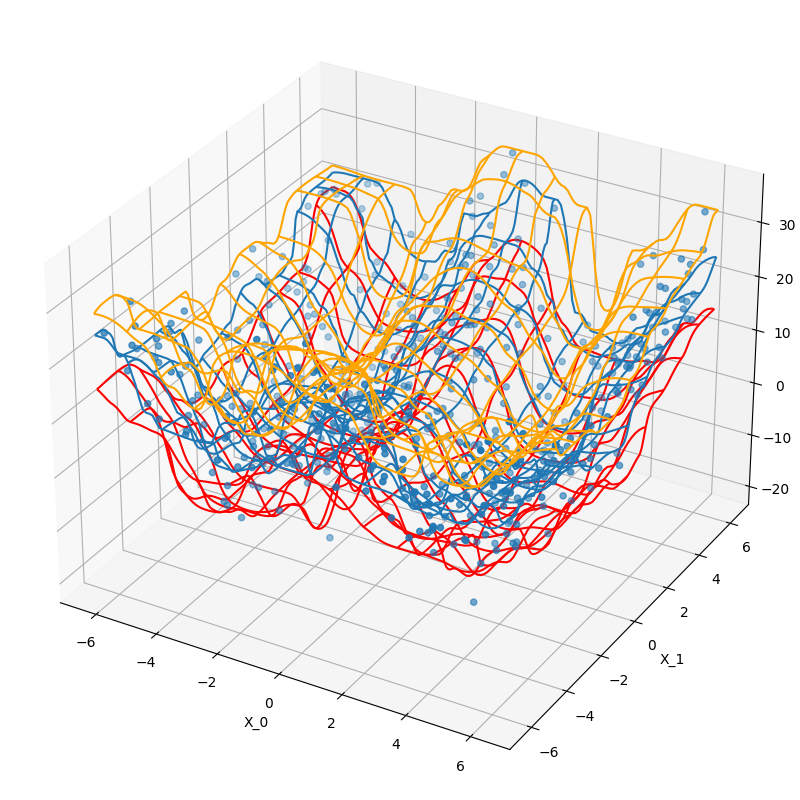

In [19]:
fig = plt.figure(figsize=(8,8))
# ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

ax.scatter(x0, x1, y)

x0_grid = x_test[:, 0].reshape((grid_size, grid_size))
x1_grid = x_test[:, 1].reshape((grid_size, grid_size))
q_grid_q10 = q_hat[:, 0].numpy().reshape((grid_size, grid_size))
q_grid_median = q_hat[:, 1].numpy().reshape((grid_size, grid_size))
q_grid_q90 = q_hat[:, 2].numpy().reshape((grid_size, grid_size))

ax.plot_wireframe(x0_grid, x1_grid, q_grid_q10, rstride=10, cstride=10, color="red")
ax.plot_wireframe(x0_grid, x1_grid, q_grid_median, rstride=10, cstride=10)
ax.plot_wireframe(x0_grid, x1_grid, q_grid_q90, rstride=10, cstride=10, color="orange")

ax.set_xlabel('X_0')
ax.set_ylabel('X_1')
ax.set_zlabel('Y')

plt.show()